In [1]:
!pip install gdown
url = "https://drive.google.com/drive/folders/15UhW0dRzPDz9N-4yPkmB2JB_rXKyE-eA?usp=drive_link"
!gdown --folder "{url}"
url = "https://drive.google.com/drive/folders/1xJECHCo9vsT6cpF_TYeKRf7WMBoJdjBk?usp=drive_link"
!gdown --folder "{url}"

Retrieving folder contents
Processing file 1zlHD17Ml7BafF7qSvClFDNxxOSfp1DgD test.csv
Processing file 1JNRPKjHh2sH31ClTxHxABlkQagt2oaVq train_1.csv
Processing file 1-y7wGtac3q4evHpYvuX1w6HKYgOJnQAv train_10.csv
Processing file 1SWW9mAB9btAR5KOfRLeiuol2-XPpoWJA train_100.csv
Processing file 1ywaSZTZqPrc4iKEXMke9KX3X3LvuBYEr val.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zlHD17Ml7BafF7qSvClFDNxxOSfp1DgD
To: /kaggle/working/RSNA/test.csv
100%|█████████████████████████████████████████| 634k/634k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JNRPKjHh2sH31ClTxHxABlkQagt2oaVq
To: /kaggle/working/RSNA/train_1.csv
100%|██████████████████████████████████████| 28.7k/28.7k [00:00<00:00, 63.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-y7wGtac3q4evHpYvuX1w6HKYgOJnQAv
To: /kaggle/working/RSNA/train_10.csv
100%|████████████████████████████

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Đường dẫn đến bộ dữ liệu RSNA
dataset_root = Path('/kaggle/input/rsna-pneumonia-detection-challenge')

train_csv = "/kaggle/working/RSNA/train_100.csv"
val_csv = "/kaggle/working/RSNA/val.csv"

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
print("shape of train dataset: ", train_df.shape)
print("shape of val dataset: ", val_df.shape)

shape of train dataset:  (18144, 7)
shape of val dataset:  (4537, 7)


In [3]:
# ==========================================
# 1. CÀI ĐẶT VÀ IMPORT THƯ VIỆN CẦN THIẾT
# ==========================================
!pip install pydicom
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import pydicom
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

# ==========================================
# 2. DATASET CLASS (ĐÃ FIX LỖI ĐỌC DICOM)
# ==========================================
class RSNADataset(Dataset):
    def __init__(self, csv_file, img_root, img_col, label_col, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Lấy đường dẫn ảnh
        img_path = self.data.iloc[idx][self.img_col]
        if self.img_root:
            img_path = os.path.join(self.img_root, img_path)

        try:
            # --- FIX: Dùng pydicom để đọc file .dcm ---
            dcm = pydicom.dcmread(img_path)
            image_array = dcm.pixel_array

            # Chuẩn hóa pixel về khoảng 0-255
            if np.max(image_array) != 0:
                image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255.0
            image_array = image_array.astype(np.uint8)

            # Chuyển sang PIL Image (RGB) để dùng với transforms
            image = Image.fromarray(image_array).convert('RGB')

        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            # Trả về ảnh đen nếu lỗi để không crash
            image = Image.new('RGB', (224, 224))

        label = self.data.iloc[idx][self.label_col]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# ==========================================
# 3. CÁC HÀM TRANSFORMS & MODEL
# ==========================================
def get_transforms(is_train=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    if is_train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            normalize
        ])
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

class DownstreamModel(nn.Module):
    def __init__(self, num_classes=2, checkpoint_path=None, resnet_name="resnet50", freeze_backbone=True, unfreeze_n_block=0):
        super().__init__()
        # Backbone
        if resnet_name == "resnet18":
            self.resnet = models.resnet18(weights=None)
        else:
            self.resnet = models.resnet50(weights=None)
            
        # Load Weights
        if checkpoint_path is not None and os.path.exists(checkpoint_path):
            state_dict = torch.load(checkpoint_path, map_location="cpu")
            resnet_state_dict = {k.replace("resnet.", ""): v for k, v in state_dict.items() if k.startswith("resnet.")}
            msg = self.resnet.load_state_dict(resnet_state_dict, strict=False)
            print(f"Loaded weights from {checkpoint_path}")
# #### train 1% ####
#         # Head
#         num_ftrs = self.resnet.fc.in_features if hasattr(self.resnet.fc, "in_features") else 2048
#         self.resnet.fc = nn.Identity()
#         self.classifier = nn.Sequential(
#             nn.Linear(num_ftrs, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, num_classes)
#         )

#         # FREEZE: Đóng băng toàn bộ ResNet
#         for param in self.resnet.parameters():
#             param.requires_grad = False
            
#         # Vẫn cho BatchNorm cập nhật thống kê (chống nhiễu domain)
#         for m in self.resnet.modules():
#             if isinstance(m, nn.BatchNorm2d):
#                 m.train()
                
# #### train 10% ####
#     # Head
#         num_ftrs = self.resnet.fc.in_features if hasattr(self.resnet.fc, "in_features") else 2048
#         self.resnet.fc = nn.Identity()
#         self.classifier = nn.Sequential(
#             nn.Linear(num_ftrs, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, num_classes)
#         )

#         # FREEZE PARTIAL: Đóng băng hết trước...
#         for param in self.resnet.parameters():
#             param.requires_grad = False

#         # ...Sau đó MỞ KHÓA layer cuối cùng (layer4)
#         for param in self.resnet.layer4.parameters():
#             param.requires_grad = True

#         # Vẫn cho BatchNorm cập nhật thống kê
#         for m in self.resnet.modules():
#             if isinstance(m, nn.BatchNorm2d):
#                 m.train()
                
#### train 100% ####
# Head
        num_ftrs = self.resnet.fc.in_features if hasattr(self.resnet.fc, "in_features") else 2048
        self.resnet.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # UNFREEZE ALL: Mở khóa toàn bộ để train
        for param in self.resnet.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.classifier(self.resnet(x))

# ==========================================
# 4. TRAINING HELPERS & LOOP
# ==========================================
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.should_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_score = score
            self.counter = 0

def compute_metrics(y_true, y_logits, num_classes):
    y_true = np.array(y_true)
    y_probs = torch.softmax(torch.tensor(np.array(y_logits)), dim=1).numpy()

    # Macro AUC
    try:
        if num_classes == 2:
            auc = roc_auc_score(y_true, y_probs[:, 1])
        else:
            auc = roc_auc_score(y_true, y_probs, multi_class="ovr", average="macro")
    except ValueError:
        auc = np.nan

    # Macro F1 & Acc
    y_pred = np.argmax(y_probs, axis=1)
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = (y_pred == y_true).mean()
    return acc, auc, f1

def train_model(model, train_loader, val_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
    early_stopping = EarlyStopping(patience=config.get("patience", 5))

    history = {"train_loss": [], "train_acc": [], "train_auc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_auc": [], "val_f1": []}
    best_auc = 0.0

    print(f"Start training for {config['epochs']} epochs")

    for epoch in range(config["epochs"]):
        # TRAIN
        model.train()
        train_loss = 0.0
        y_true_train, y_logits_train = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images, labels = images.to(config["device"]), labels.to(config["device"])
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            y_true_train.extend(labels.cpu().numpy())
            y_logits_train.extend(outputs.detach().cpu().numpy())

        train_acc, train_auc, train_f1 = compute_metrics(y_true_train, y_logits_train, config["num_classes"])

        # VAL
        model.eval()
        val_loss = 0.0
        y_true_val, y_logits_val = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images, labels = images.to(config["device"]), labels.to(config["device"])
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                y_true_val.extend(labels.cpu().numpy())
                y_logits_val.extend(outputs.cpu().numpy())

        val_acc, val_auc, val_f1 = compute_metrics(y_true_val, y_logits_val, config["num_classes"])

        # Logging
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc)
        history["train_auc"].append(train_auc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch+1}: Train AUC={train_auc:.4f} | Val AUC={val_auc:.4f}")

        scheduler.step(val_auc)
        early_stopping(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_rsna_model.pth")
            print(f"✅ Saved best model (Val AUC = {best_auc:.4f})")

        if early_stopping.should_stop:
            print("⏹ Early stopping triggered")
            break

    return history

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
# Cấu hình
finetune_config = {
    "batch_size": 32,
    "epochs": 15,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "num_classes": 2, 
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "pretrained_path": "/kaggle/working/softmaxloss/checkpoints/model.pth",
    "train_csv": "/kaggle/working/RSNA/train_100.csv", 
    "val_csv": "/kaggle/working/RSNA/val.csv",
    "img_col": "image_path",
    "label_col": "Target",
    "patience": 5
}

# Khởi tạo Dataset & Loader
train_name = os.path.basename(finetune_config["train_csv"])
print(f"🚀 ĐANG TRAIN TRÊN TẬP DỮ LIỆU: {train_name}")
print("🔄 Initializing Datasets...")
train_ds = RSNADataset(finetune_config["train_csv"], "", finetune_config["img_col"], finetune_config["label_col"], transform=get_transforms(True))
val_ds = RSNADataset(finetune_config["val_csv"], "", finetune_config["img_col"], finetune_config["label_col"], transform=get_transforms(False))

train_loader = DataLoader(train_ds, batch_size=finetune_config["batch_size"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=finetune_config["batch_size"], shuffle=False, num_workers=2)

# Khởi tạo Model
print("🔄 Initializing Model...")
model = DownstreamModel(num_classes=finetune_config["num_classes"], checkpoint_path=finetune_config["pretrained_path"]).to(finetune_config["device"])

# Chạy Train
print("🚀 Starting Training...")
history = train_model(model, train_loader, val_loader, finetune_config)

🚀 ĐANG TRAIN TRÊN TẬP DỮ LIỆU: train_100.csv
🔄 Initializing Datasets...
🔄 Initializing Model...
Loaded weights from /kaggle/working/softmaxloss/checkpoints/model.pth


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Starting Training...
Start training for 15 epochs


Epoch 1 [Val]: 100%|██████████| 142/142 [01:05<00:00,  2.17it/s]


Epoch 1: Train AUC=0.8436 | Val AUC=0.8691
✅ Saved best model (Val AUC = 0.8691)


Epoch 2 [Val]: 100%|██████████| 142/142 [00:45<00:00,  3.13it/s]


Epoch 2: Train AUC=0.8663 | Val AUC=0.8767
✅ Saved best model (Val AUC = 0.8767)


Epoch 3 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.20it/s]


Epoch 3: Train AUC=0.8746 | Val AUC=0.8757


Epoch 4 [Val]: 100%|██████████| 142/142 [00:45<00:00,  3.15it/s]


Epoch 4: Train AUC=0.8833 | Val AUC=0.8753


Epoch 5 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.16it/s]


Epoch 5: Train AUC=0.8845 | Val AUC=0.8809
✅ Saved best model (Val AUC = 0.8809)


Epoch 6 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.19it/s]


Epoch 6: Train AUC=0.8885 | Val AUC=0.8811
✅ Saved best model (Val AUC = 0.8811)


Epoch 7 [Val]: 100%|██████████| 142/142 [00:45<00:00,  3.09it/s]


Epoch 7: Train AUC=0.8942 | Val AUC=0.8770


Epoch 8 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.16it/s]


Epoch 8: Train AUC=0.8986 | Val AUC=0.8819
✅ Saved best model (Val AUC = 0.8819)


Epoch 9 [Val]: 100%|██████████| 142/142 [00:45<00:00,  3.09it/s]


Epoch 9: Train AUC=0.9039 | Val AUC=0.8781


Epoch 10 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.18it/s]


Epoch 10: Train AUC=0.9073 | Val AUC=0.8836
✅ Saved best model (Val AUC = 0.8836)


Epoch 11 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.19it/s]


Epoch 11: Train AUC=0.9134 | Val AUC=0.8777


Epoch 12 [Val]: 100%|██████████| 142/142 [00:43<00:00,  3.24it/s]


Epoch 12: Train AUC=0.9151 | Val AUC=0.8592


Epoch 13 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.21it/s]


Epoch 13: Train AUC=0.9206 | Val AUC=0.8753


Epoch 14 [Val]: 100%|██████████| 142/142 [00:45<00:00,  3.11it/s]


Epoch 14: Train AUC=0.9365 | Val AUC=0.8771


Epoch 15 [Val]: 100%|██████████| 142/142 [00:44<00:00,  3.21it/s]

Epoch 15: Train AUC=0.9389 | Val AUC=0.8759
⏹ Early stopping triggered


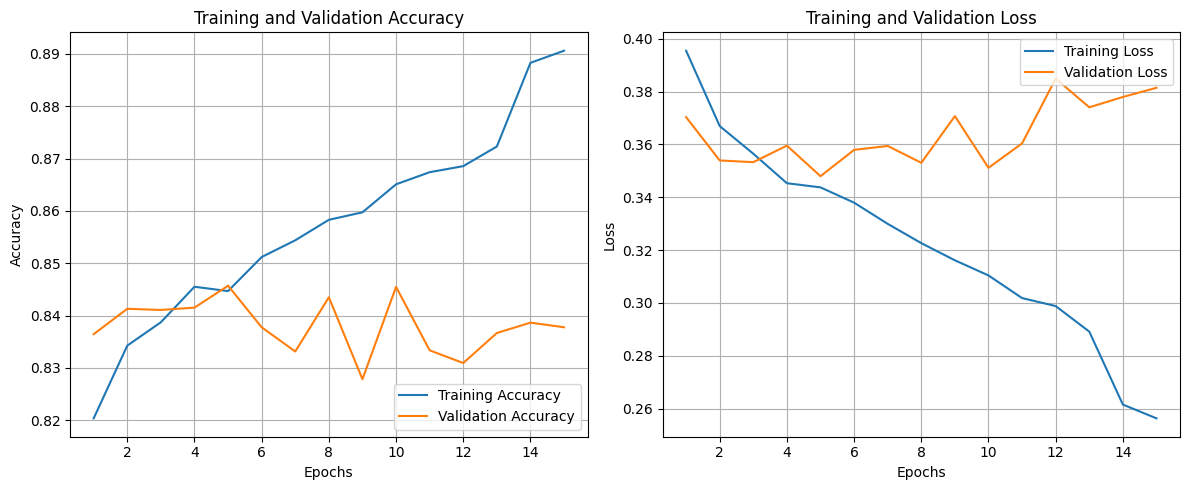

In [4]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ
plot_training_history(history)


In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import numpy as np

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()

    y_true = []
    y_logits = []

    # 1. Chạy dự đoán
    print(f"🔄 Đang chạy đánh giá trên {len(dataloader.dataset)} mẫu...")
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            y_true.extend(labels.cpu().numpy())
            y_logits.extend(outputs.cpu().numpy())

    # 2. Xử lý kết quả
    y_true = np.array(y_true)
    y_logits = np.array(y_logits)
    # Chuyển logits thành xác suất (0-1) bằng Softmax
    y_probs = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
    # Lấy nhãn dự đoán (lớp có xác suất cao nhất)
    y_pred = np.argmax(y_probs, axis=1)

    # 3. Tính toán các chỉ số
    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Macro F1
    f1 = f1_score(y_true, y_pred, average="macro")

    # AUC (Fix lỗi Binary vs Multiclass)
    try:
        if num_classes == 2:
            # Nếu là 2 lớp (Binary), chỉ lấy cột xác suất của lớp 1 (Positive)
            auc = roc_auc_score(y_true, y_probs[:, 1])
        else:
            # Nếu nhiều lớp, dùng chiến lược One-vs-Rest
            auc = roc_auc_score(y_true, y_probs, multi_class="ovr", average="macro")
    except ValueError:
        # Trường hợp lỗi (ví dụ: tập test chỉ có 1 lớp duy nhất)
        auc = 0.5 

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "macro_auc": auc
    }

In [6]:
test_csv_path = "/kaggle/working/RSNA/test.csv" 

test_ds = RSNADataset(
    test_csv_path, 
    finetune_config.get("img_root", ""), # Lấy từ config hoặc để trống
    finetune_config["img_col"], 
    finetune_config["label_col"], 
    transform=get_transforms(is_train=False) # Quan trọng: Không Augmentation
)

# 3. Tạo DataLoader 
# FIX LỖI: Phải truyền 'test_ds' vào, code cũ bạn đang truyền 'val_ds'
test_loader = DataLoader(
    test_ds, 
    batch_size=finetune_config["batch_size"], 
    shuffle=False, 
    num_workers=2
)

# 4. Chạy đánh giá
# FIX LỖI: RSNA là bài toán 2 lớp (0/1), nên num_classes=2
metrics = evaluate_model(
    model,
    test_loader,
    device=finetune_config["device"],
    num_classes=2 
)

# 5. In kết quả
print("\n" + "="*40)
print(f"📊 KẾT QUẢ TRÊN TẬP TEST ({len(test_ds)} ảnh)")
print("="*40)
print(f"✅ Test Accuracy: {metrics['accuracy']:.4f}")
print(f"✅ Macro F1:      {metrics['macro_f1']:.4f}")
print(f"✅ Macro AUC:     {metrics['macro_auc']:.4f}")
print("="*40)

🔄 Đang chạy đánh giá trên 4003 mẫu...

📊 KẾT QUẢ TRÊN TẬP TEST (4003 ảnh)
✅ Test Accuracy: 0.8401
✅ Macro F1:      0.7566
✅ Macro AUC:     0.8791
